In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#path = '/content/drive/MyDrive/NLU/1-restaurant-train.csv'
#path = '/content/drive/MyDrive/NLU_Assignment2/Module2/1-restaurant-train.csv'
path = '/content/drive/MyDrive/NLU/OptimizedDataset.csv'

In [ ]:
!pip install "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
#df = pd.read_csv(path,sep=' """|\t',on_bad_lines='skip')[:10000]
df = pd.read_csv(path)

In [ ]:
#df.columns = ['Reviews','Rating']
print(df.shape)
df.head()

(40000, 3)


,Unnamed: 0,Reviews,Rating
0,0,thank thank thank i want thank people made pla...,4
1,1,a humane society store biltmore interesting i ...,5
2,2,dont buy nike sneaker want return exchange ive...,1
3,3,i say i love thing sprouts especially particul...,3
4,4,the tire pressure light came day ago i husband...,5


In [ ]:
df.columns

Index(['Unnamed: 0', 'Reviews', 'Rating'], dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [ ]:
df['Reviews'] = df['Reviews'].str.lower()

In [ ]:
df.sample(5)

,Reviews,Rating
10043,this place a customer service all staff intera...,5
37530,35 starsnnquaint resort hotel adjacent lake th...,4
9629,first i havent hob nobs coffee i go veggie mon...,3
19856,thai house one restaurant isnt afraid flavor s...,4
25340,110412nnhuge asian festival fail onnnbrought a...,3


In [ ]:
df['Rating'].value_counts()

4    13694
5    11860
3     6812
2     4328
1     3306
Name: Rating, dtype: int64

In [ ]:
num_classes = len(df["Rating"].value_counts())
num_classes

5

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# y = tf.keras.utils.to_categorical(df['labels'].values, num_classes=6)
# y
import numpy as np
y=np.array(df['Rating'])
y=y-1
print(y)
y=tf.keras.utils.to_categorical(y)

[3 4 0 ... 1 2 4]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'],y,random_state = 42)

In [ ]:
len(X_train),len(X_test)

(30000, 10000)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']
get_sentence_embeding(['Himanshu','Kumar','Anand'])

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.82798934, -0.3457806 ,  0.02205429, ..., -0.06123677,
        -0.62139994,  0.7826482 ],
       [-0.9019336 , -0.31737137,  0.0287143 , ...,  0.14343937,
        -0.64128155,  0.8567765 ],
       [-0.78347164, -0.18660241,  0.4322806 , ...,  0.36925185,
        -0.51577973,  0.74956125]], dtype=float32)>

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers (dropout-dense-dense)
drop_out = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
dense1 = tf.keras.layers.Dense(64,activation='relu')(drop_out)
dense2 = tf.keras.layers.Dense(16,activation='relu')(dense1)
output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output")(dense2)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [output_layer])
#model = tf.keras.Model(text_input,l)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_text[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              #loss='binary_crossentropy',
               #loss='sparse_categorical_crossentropy',
              metrics=METRICS)

In [ ]:
history = model.fit(X_train, y_train,validation_split = 0.2, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


750/750 [==============================] - 663s 867ms/step - loss: 1.4304 - accuracy: 0.3575 - precision: 0.4983 - recall: 0.0120 - val_loss: 1.3699 - val_accuracy: 0.3767 - val_precision: 0.5680 - val_recall: 0.0668
Epoch 2/10
750/750 [==============================] - 649s 865ms/step - loss: 1.3650 - accuracy: 0.3883 - precision: 0.5604 - recall: 0.0417 - val_loss: 1.3214 - val_accuracy: 0.3988 - val_precision: 0.6263 - val_recall: 0.0310
Epoch 3/10
750/750 [==============================] - 643s 858ms/step - loss: 1.3387 - accuracy: 0.4005 - precision: 0.5689 - recall: 0.0652 - val_loss: 1.3286 - val_accuracy: 0.4073 - val_precision: 0.5835 - val_recall: 0.1182
Epoch 4/10
750/750 [==============================] - 644s 859ms/step - loss: 1.3279 - accuracy: 0.4028 - precision: 0.5727 - recall: 0.0858 - val_loss: 1.3077 - val_accuracy: 0.4137 - val_precision: 0.7010 - val_recall: 0.0453
Epoch 5/10
750/750 [==============================] - 646s 861ms/step - loss: 1.3237 - accuracy: 0.

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 220s 703ms/step - loss: 1.3018 - accuracy: 0.4240 - precision: 0.5893 - recall: 0.1376


[1.301771640777588,
 0.42399999499320984,
 0.589293360710144,
 0.13760000467300415]

In [ ]:
model.metrics_names

['loss', 'accuracy', 'precision', 'recall']

In [ ]:
from matplotlib import pyplot as plt

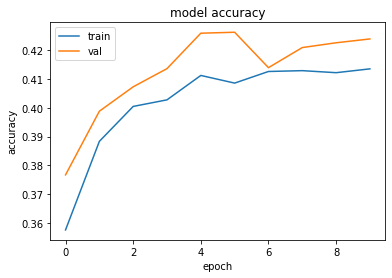

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

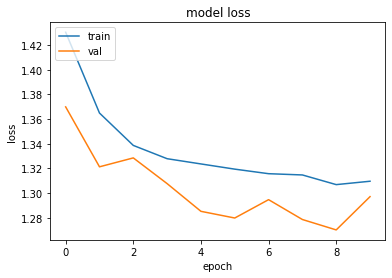

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred[:5]

array([[0.01175759, 0.030585  , 0.1221454 , 0.3711581 , 0.4643539 ],
       [0.04024974, 0.05124094, 0.11971861, 0.3231816 , 0.46560904],
       [0.00850754, 0.02138553, 0.0940711 , 0.3909297 , 0.4851062 ],
       [0.00076456, 0.00366624, 0.02997354, 0.34785506, 0.6177406 ],
       [0.00820815, 0.01936453, 0.07737984, 0.34808183, 0.54696566]],
      dtype=float32)

In [ ]:
predictions = [np.argmax(i) for i in pred]

In [ ]:
predictions[:5]

[4, 4, 4, 4, 4]

In [ ]:
p=[]
for i in predictions:
  p.append(i+1)

In [ ]:
from collections import Counter

In [ ]:
Counter(p)

Counter({1: 422, 2: 34, 3: 68, 4: 5616, 5: 3860})